# Assignment 1 - Water Quality

## Given

In this project, we provide a water quality dataset from the Central Pollution Control Board
(CPCB). You will use this dataset to predict water quality.

Access to clean water is a fundamental necessity, yet water quality can vary significantly based
on environmental, geographical, and human factors. The dataset includes water quality
monitoring data from across India, with chemical and physical parameters measured at various
locations over different years (2019, 2020, 2021, 2022).

The dataset contains the following columns:
pi
Well_ID, State, District, Block, Village: Geographical identifiers of water sampling locations.

Latitude, Longitude: Spatial coordinates for precise mapping.

Year: The year in which the sample was recorded.

Water Quality Indicators: pH, Electrical Conductivity (EC), Carbonates (CO3), Bicarbonates
(HCO3), Chlorides (CI), Sulfates (SO4), Nitrates (NO3), Total Hardness (TH), Calcium (Ca),
Magnesium (Mg), Sodium (Na), Potassium (K), Fluoride (F), Total Dissolved Solids (TDS).

Target Variables:

Water Quality Index (WQI): A numerical representation of overall water quality derived from
chemical and physical parameters.

Water Quality Classification: A categorical label indicating the quality of water (e.g., Good, Poor,
Unsuitable for Drinking).

## Deliverables

In this project, your task is to build Deep Learning Neural Networks to predict the following:

Water Quality Index (WQI)

Water Quality Classification

You can download the dataset from the attachment provided and build the models using that.
Once the models are built, calculate metrics such as the R2 score for regression and accuracy/F1
score for classification, and submit your ipynb file for evaluation.

As a preliminary analysis upon checking the given, we notice that the columns mentioned display a certain redundancy:
- Geographical identifiers of water sampling locations and Spatial coordinates for precise mapping present us with the same insights so I will stick with the Latitude and Longitude as geographical indicators
- The year seems to be irrelevant due to the lack of interpretability 
- The water quality indicators are the most relevant factors to consider

## TODO

- [ ] Transform Targets (Use Log `y_wqi_train_log = np.log1p(y_wqi_train)` and `y_wqi_pred = np.expm1(y_wqi_pred_log)`)
- [ ] Visualize the distribution of the features before and after transformation.
- [ ] A bit more complex model?

## Imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score, f1_score
import numpy as np


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

## EDA

In [2]:
# Loading data
df = pd.read_csv('../xx_data/water_quality.csv')

df.head()

,Well_ID,State,District,Block,Village,Latitude,Longitude,Year,pH,EC,...,NO3,TH,Ca,Mg,Na,K,F,TDS,WQI,Water Quality Classification
0,W232200071580001,Gujarat,Ahmedabad,Mandal,Dalod,NaN,NaN,2020,8.20,16640.0,...,26.00,1451.0,152.0,260.0,3535.0,45.0,1.00,11149,4361.44080,Unsuitable for Drinking
1,W254029084355301,Himachal Pradesh,Solan,Nallagarh,JAGATPUR,31.1594,76.678500,2019,8.44,299.0,...,2.70,84.0,17.0,10.0,39.0,2.4,0.20,262,85.80466,Good
2,W193530074180001,Maharashtra,Ahmednagar,SANGAMNER,Kokangaon,74.3000,19.591667,2022,7.90,1315.0,...,18.20,465.0,80.2,64.4,88.3,1.6,0.53,372,280.04130,Very Poor yet Drinkable
3,W231620072033001,Gujarat,Ahmedabad,Viramgam,Endla,NaN,NaN,2020,7.40,715.0,...,0.23,280.0,56.0,34.0,47.0,11.0,0.46,479,195.11649,Poor
4,W251908084361501,Himachal Pradesh,Solan,Nallagarh,BARUNA,31.1540,76.638400,2019,8.40,270.0,...,10.00,116.0,10.0,18.0,23.0,1.0,0.12,262,81.77860,Good


In [3]:
print(f"The dataset contains the following columns:\n{", ".join(df.columns.to_list())}")

The dataset contains the following columns:
Well_ID, State, District, Block, Village, Latitude, Longitude, Year, pH, EC, CO3, HCO3, Cl, SO4, NO3, TH, Ca, Mg, Na, K, F, TDS, WQI, Water Quality Classification


### 📌 Dropping Location and Metadata Columns

We drop the columns `Well_ID`, `State`, `District`, `Block`, `Village`, `Latitude`, `Longitude`, and `Year` because they do not contribute directly to assessing water quality. These fields serve as identifiers or contextual metadata, while the dataset already includes precise chemical measurements (e.g., pH, TDS, NO₃) that directly determine water quality. By removing non-essential columns, we streamline the dataset and focus the analysis on the actual water quality indicators.

### 🎯 Target Variable Selection

We use **Water Quality Index (WQI)** as the target variable for modeling and prediction, rather than the `Water Quality Classification`. The classification is a **direct categorical interpretation** of the WQI value, as shown in the reference table:

![WQI vs WQC table](https://pubs.sciepub.com/ajwr/1/3/3/image/tab2.png)

Since the classification is **derived directly from WQI**, including both as targets would be redundant. By predicting WQI, we can **infer the classification** using predefined thresholds, keeping the model focused and avoiding leakage from derived labels.

### 📊 Investigating the WQI–Classification Relationship

We created a boxplot to investigate whether the `Water Quality Classification` aligns correctly with the `Water Quality Index (WQI)` values. Since the classification is derived from WQI ranges, this visualization helps validate the hypothesis that the classification labels are consistent with the underlying index. By plotting WQI against each classification category, we can visually confirm whether the WQI values fall within the expected thresholds defined in the reference table. This step ensures the integrity of the labels and supports using WQI as the sole target variable for modeling.

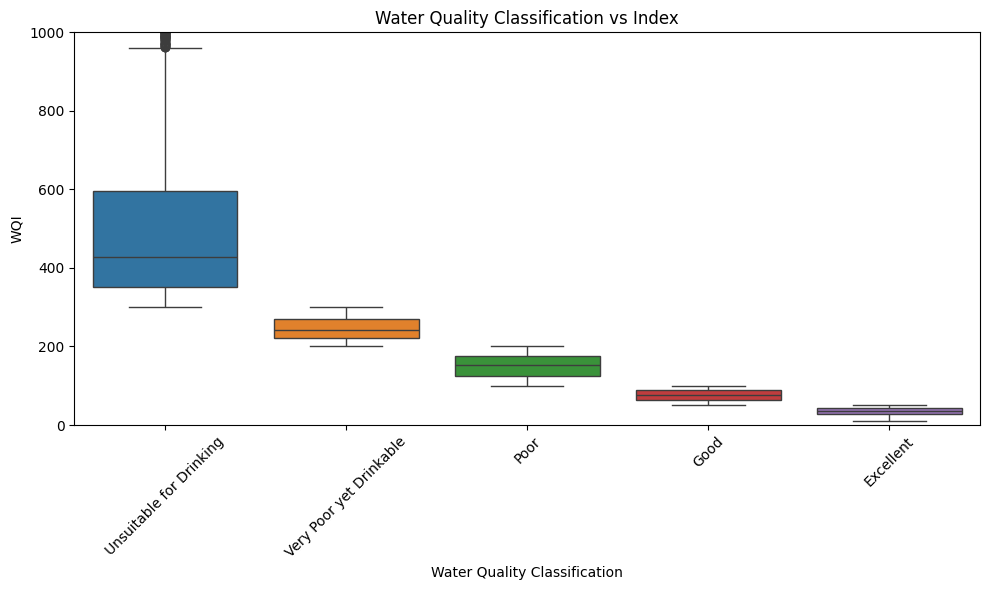

In [4]:
# Create scatter plot
plt.figure(figsize=(10, 6))

# Define desired order for classification
classification_order = ['Unsuitable for Drinking', 'Very Poor yet Drinkable', 'Poor', 'Good', 'Excellent']

df['Water Quality Classification'] = pd.Categorical(
    df['Water Quality Classification'],
    categories=classification_order,
    ordered=True
)

sns.boxplot(
    x='Water Quality Classification',
    y="WQI", 
    data=df,
    hue='Water Quality Classification'
)

# Customize plot
plt.title('Water Quality Classification vs Index')
plt.xlabel('Water Quality Classification')
plt.ylabel('WQI')
plt.ylim([0, 1000])
plt.xticks(rotation=45)
plt.tight_layout()

The plot clearly demonstrates that the **Water Quality Index (WQI)** serves as a direct and reliable indicator for water quality classification. Each classification corresponds to a specific WQI range, meaning the label assigned to a data point is determined solely by the interval in which its WQI value falls. Given this strong correlation, we include **WQI as a predictor** in our modeling pipeline, allowing us to infer the classification programmatically and ensure consistency across the dataset.

In [5]:
# Group by classification and calculate min and max WQI
wqi_stats = df.groupby('Water Quality Classification', observed=False)['WQI'].agg(['min', 'max']).reset_index()

# Display the result
print("Minimum and Maximum WQI values for each Water Quality Classification:")
wqi_stats

Minimum and Maximum WQI values for each Water Quality Classification:


,Water Quality Classification,min,max
0,Unsuitable for Drinking,300.011380,6850.88872
1,Very Poor yet Drinkable,200.011080,299.99592
2,Poor,100.019120,199.99532
3,Good,50.026635,99.92520
4,Excellent,9.043604,49.95470


### 🧠 Inferring Water Quality Classification from WQI

Based on the observed WQI ranges for each classification, we define the following logic to infer the water quality category directly from the Water Quality Index (WQI):

In [6]:
def classify_water_quality(wqi):
    if wqi >= 300:
        return "Unsuitable for Drinking"
    elif wqi >= 200:
        return "Very Poor yet Drinkable"
    elif wqi >= 100:
        return "Poor"
    elif wqi >= 50:
        return "Good"
    elif wqi >= 0:
        return "Excellent"
    else:
        return "Unknown"

This function uses the minimum WQI thresholds observed in each category to assign a classification. It ensures consistency with the dataset and allows automatic labeling based on WQI values.

# Data Preprocessing

Based on the discussions above, we drop the geographical data and the year.

In [7]:
df.drop(
    columns=['Well_ID', 'State', 'District', 'Block', 'Village', 'Latitude', 'Longitude', 'Year'],
    inplace=True
)

df.head(2)

,pH,EC,CO3,HCO3,Cl,SO4,NO3,TH,Ca,Mg,Na,K,F,TDS,WQI,Water Quality Classification
0,8.20,16640.0,0.0,1257.0,5176.0,822.0,26.0,1451.0,152.0,260.0,3535.0,45.0,1.0,11149,4361.44080,Unsuitable for Drinking
1,8.44,299.0,43.0,87.0,21.0,0.0,2.7,84.0,17.0,10.0,39.0,2.4,0.2,262,85.80466,Good


We check if the data has nulls and it has no nulls

In [8]:
columns_with_nans = df.columns[df.isna().any()].tolist()

# Print the names of columns with NaNs
print("Columns with NaNs:", columns_with_nans)
print("Number of columns with nans:", len(columns_with_nans))

Columns with NaNs: []
Number of columns with nans: 0


We split it into train and test, using the `WQI` as target (for training), but Keeping the Classification for accuracy calculations (Testing).

In [9]:
X = df.drop(columns=['WQI', 'Water Quality Classification'], axis=1)
y = df[['WQI', 'Water Quality Classification']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [10]:
y_wqi_train = y_train['WQI']
y_wqi_train_log = np.log1p(y_wqi_train)
y_wqc_train = y_train['Water Quality Classification']
y_wqi_test = y_test['WQI']
y_wqi_test_log = np.log1p(y_wqi_test)
y_wqc_test = y_test['Water Quality Classification']

Since we have only numerical variable, we will apply only the numerical transformer.

In [ ]:
X_scaler = StandardScaler()

X_train = X_scaler.fit_transform(X_train)
X_test = X_scaler.transform(X_test)

X_train[:2]

array([[-0.02979018,  0.14572786, -0.21650563,  0.67652914, -0.24683136,
         0.5050919 ,  1.04398112,  0.19419423,  0.36278412,  0.00505237,
        -0.16240853,  1.35589558, -0.05781317,  0.51670154],
       [ 0.98476914, -0.30243767, -0.21650563, -0.42527374, -0.10692488,
        -0.30711344, -0.49048852, -0.44246857, -0.87577075, -0.37608272,
         0.22038292,  0.71139077,  0.02990003, -0.46028393]])

We convert the NumPy arrays into Torch Tensors.

In [12]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_wqi_train_log, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_wqi_test_log.values.reshape(-1,1), dtype=torch.float32)

Text(0.5, 1.0, 'Before log-transformation')

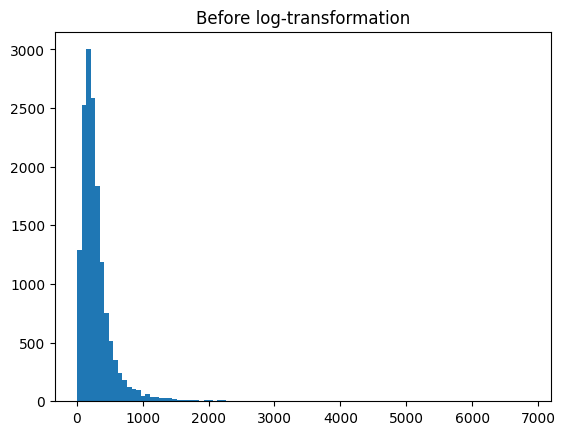

In [55]:
plt.hist(y_wqi_train, bins=100)
plt.title("Before log-transformation")

In [62]:
y_scaler = StandardScaler()

y_wqi_train = y_scaler.fit_transform(y_wqi_train_log.values.reshape(-1,1))

Text(0.5, 1.0, 'After Log Transformation')

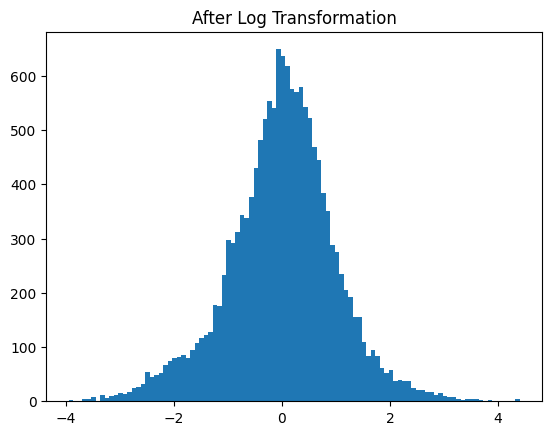

In [63]:
plt.hist(y_wqi_train, bins=100)
plt.title("After Log Transformation")

After log-transformation, the target has a normal distribution.

## NN Model

We will use MSE.

In [15]:
def mse_loss(y_pred, y_true):
    # Compute squared error
    squared_error = (y_pred - y_true) ** 2
    
    # Return mean of squared error
    return torch.mean(squared_error)

In [16]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Define the three linear layers
        self.fc1 = nn.Linear(X_test_tensor.shape[1], 8)
        self.fc2 = nn.Linear(8, 1)
        
    def forward(self, x):
        # Pass x through linear layers adding activations
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x

In [17]:
train_data = TensorDataset(X_train_tensor, y_train_tensor)

In [18]:
model = Net()

optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum=0.9)

train_loss_list=[]
test_loss_list = []

num_epochs = 300

train_loader = DataLoader(train_data, batch_size= 64, shuffle=True) 

In [19]:
# Execute the training loop
for epoch in range(num_epochs): # increasing the epochs for effective training
    for X_batch, y_batch in train_loader:
        # Forward pass
        pred = model(X_batch)
        loss = mse_loss(pred, y_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss = mse_loss(model(X_train_tensor), y_train_tensor).item()
    test_loss = mse_loss(model(X_test_tensor), y_test_tensor).item()
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
    if (epoch+1) % 10 == 0 or epoch == 0: # printing after every 10 epochs
        print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
    

Epoch 1: Train Loss: 0.6832, Test Loss: 0.7154
Epoch 10: Train Loss: 0.6015, Test Loss: 0.5581
Epoch 20: Train Loss: 0.5990, Test Loss: 0.5513
Epoch 30: Train Loss: 0.5999, Test Loss: 0.5248
Epoch 40: Train Loss: 0.5986, Test Loss: 0.5569
Epoch 50: Train Loss: 0.5987, Test Loss: 0.5448
Epoch 60: Train Loss: 0.5986, Test Loss: 0.5460
Epoch 70: Train Loss: 0.5986, Test Loss: 0.5553
Epoch 80: Train Loss: 0.5989, Test Loss: 0.5457
Epoch 90: Train Loss: 0.5997, Test Loss: 0.5364
Epoch 100: Train Loss: 0.5989, Test Loss: 0.5388
Epoch 110: Train Loss: 0.5992, Test Loss: 0.5471
Epoch 120: Train Loss: 0.5987, Test Loss: 0.5478
Epoch 130: Train Loss: 0.5992, Test Loss: 0.5494
Epoch 140: Train Loss: 0.5988, Test Loss: 0.5402
Epoch 150: Train Loss: 0.5990, Test Loss: 0.5602
Epoch 160: Train Loss: 0.5991, Test Loss: 0.5506
Epoch 170: Train Loss: 0.5995, Test Loss: 0.5356
Epoch 180: Train Loss: 0.6012, Test Loss: 0.5558
Epoch 190: Train Loss: 0.5996, Test Loss: 0.5399
Epoch 200: Train Loss: 0.5994, 

## Evaluation

In [50]:
# Predict WQI values using X_test
y_wqi_pred_log = model(X_test_tensor).detach().numpy()

# Calculate R² score
r2 = r2_score(y_test_tensor, y_wqi_pred_log)

# Print the R² score
print(f"R² score for WQI prediction: {r2:.4f}")

R² score for WQI prediction: 0.0269


In [48]:
y_wqi_pred

array([[5.4512863],
       [5.4500685],
       [5.477727 ],
       ...,
       [5.4599133],
       [5.4546437],
       [5.4648576]], shape=(3806, 1), dtype=float32)

In [53]:
y_test_tensor

tensor([[5.3960],
        [5.5171],
        [5.9949],
        ...,
        [5.7845],
        [5.6573],
        [6.3012]])

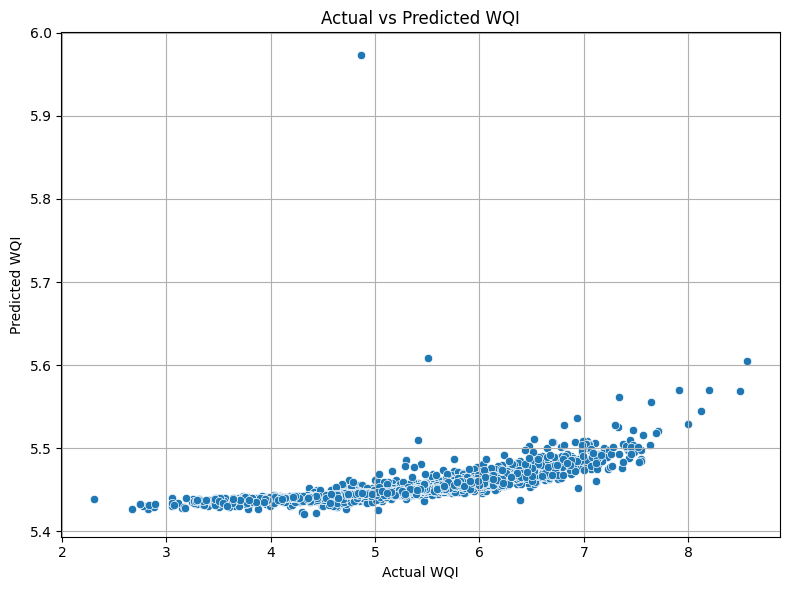

In [54]:
# Create a DataFrame for plotting
df_plot = pd.DataFrame({
    'Actual WQI': y_test_tensor.flatten(),
    'Predicted WQI': y_wqi_pred_log.flatten()
})

# Create scatter plot using seaborn
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Actual WQI', y='Predicted WQI', data=df_plot)
plt.title('Actual vs Predicted WQI')
plt.xlabel('Actual WQI')
plt.ylabel('Predicted WQI')
plt.grid(True)
plt.tight_layout()

In [33]:
y_wqi_pred = pd.Series(y_wqi_pred.flatten())

# Apply classification function to predicted WQI values
y_wqc_pred = y_wqi_pred.apply(classify_water_quality)

# Calculate accuracy and F1 score
accuracy = accuracy_score(y_wqc_test, y_wqc_pred)
f1 = f1_score(y_wqc_test, y_wqc_pred, average='weighted')

# Display results
accuracy, f1

(0.03704676826064109, 0.002646868165568986)